In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math, os, sys
from matplotlib import pyplot as plt 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import raw_process4 as raw_process

In [4]:
with open("flat.jpg", "rb") as input_file:
    whole_data = input_file.read()
data = whole_data[-10237440:]

In [5]:
bayer_pattern = np.array([[2, 1], [1, 0]])
raw_w = 3282  # for v1.3 w = 2592
raw_h = 2480  # for v1.3 h = 1944
img = np.zeros((raw_h, raw_w))
stride = math.ceil(raw_w * 10 / 8 / 32) * 32
for y in range(raw_h):
    for x in range(raw_w // 4):
        word = data[y * stride + x * 5: y * stride + x * 5 + 5]
        img[y, 4 * x    ] = (word[0] << 2) | ((word[4] >> 6) & 3) 
        img[y, 4 * x + 1] = (word[1] << 2) | ((word[4] >> 4) & 3) 
        img[y, 4 * x + 2] = (word[2] << 2) | ((word[4] >> 2) & 3) 
        img[y, 4 * x + 3] = (word[3] << 2) | ((word[4]     ) & 3)

In [6]:
# Crop to the multiple of 32x32
w = 3264
h = 2464
img_clp = img[0:h, 8:8+w]

In [7]:
blacklevel = [64] * 4
blc_raw = raw_process.black_level_correction(img_clp, blacklevel)

In [8]:
wbg = np.array([1.105, 1, 2.609, 1])
wb_raw = raw_process.white_balance_Bayer(blc_raw, wbg, bayer_pattern)

In [9]:
dms_img = raw_process.advanced_demosaic(wb_raw, bayer_pattern)

In [10]:
ccm_matrix = (6022,-2314,394,-936,4728,310,300,-4324,8126)
img_ccm = raw_process.color_correction_matrix(dms_img, ccm_matrix)

In [11]:
img_ccm[img_ccm > 1023] = 1023
img_no_shading = raw_process.gamma_correction(img_ccm, 2.2)

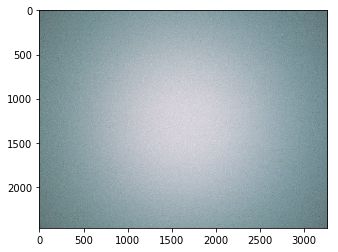

In [12]:
outimg = img_no_shading.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
plt.imshow(outimg)

In [32]:
center_y, center_x = h // 2, w // 2
shading_profile = [[], [], []]
y = center_y - 16
for x in range(0, w - 32, 32):
    xx = x + 16
    shading_profile[0].append(img_no_shading[y:y+32, x:x+32, 0].mean())
    shading_profile[1].append(img_no_shading[y:y+32, x:x+32, 1].mean())
    shading_profile[2].append(img_no_shading[y:y+32, x:x+32, 2].mean())
shading_profile = [np.array(a) / max(a) for a in shading_profile]

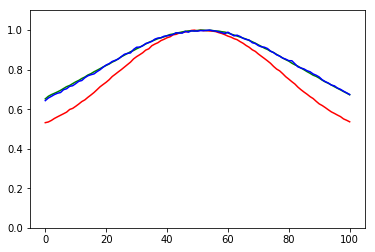

In [33]:
plt.axis(ymin=0, ymax=1.1)
plt.plot(shading_profile[0], color='red')
plt.plot(shading_profile[1], color='green')
plt.plot(shading_profile[2], color='blue')
plt.show()

In [14]:
center_y, center_x = h // 2, w // 2
vals = [[], [], [], []]
radials = []
index = 0
for y in range(0, h, 32):
    for x in range(0, w - 32, 32):
        xx = x + 16
        yy = y + 16
        r2 = (yy - center_y) * (yy - center_y) + (xx - center_x) * (xx - center_x)
        vals[0].append(blc_raw[y:y+32:2, x:x+32:2].mean())
        vals[1].append(blc_raw[y:y+32:2, x+1:x+32:2].mean())
        vals[2].append(blc_raw[y+1:y+32:2, x:x+32:2].mean())
        vals[3].append(blc_raw[y+1:y+32:2, x+1:x+32:2].mean())
        radials.append(r2)

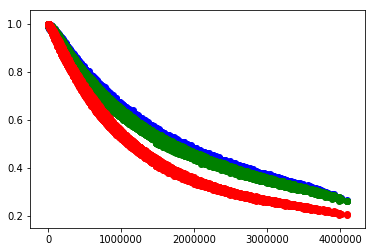

In [15]:
rs = np.array(radials)
vs = np.array(vals)
norm = vs.max(axis=1)
vs[0, :] /= vs[0, :].max()
vs[1, :] /= vs[1, :].max()
vs[2, :] /= vs[2, :].max()
vs[3, :] /= vs[3, :].max()
plt.scatter(rs, vs[0,:], color='blue')
plt.scatter(rs, vs[1,:], color='green')
plt.scatter(rs, vs[2,:], color='green')
plt.scatter(rs, vs[3,:], color='red')
plt.show()

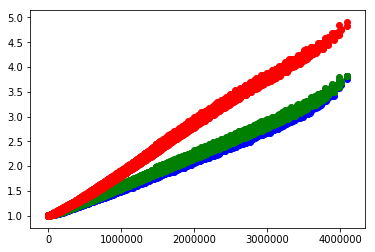

In [16]:
gs = 1 / vs
plt.scatter(rs, gs[0,:], color='blue')
plt.scatter(rs, gs[1,:], color='green')
plt.scatter(rs, gs[2,:], color='green')
plt.scatter(rs, gs[3,:], color='red')
plt.show()

In [17]:
par = [[], [], [], []]
for i in range(4):
    par[i] = np.polyfit(rs, gs[i, :], 1)

In [18]:
print(par)

[array([6.07106808e-07, 9.60556906e-01]), array([6.32044369e-07, 9.70694361e-01]), array([6.28455183e-07, 9.72493898e-01]), array([9.58743579e-07, 9.29427169e-01])]


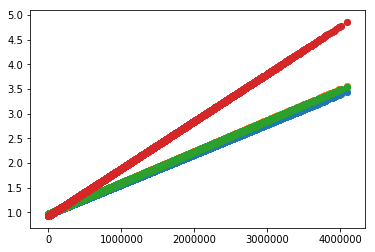

In [19]:
es = [[], [], [], []]
for i in range(4):
    es[i] = par[i][0] * rs + par[i][1]
for i in range(4):
    plt.scatter(rs, es[i])
plt.show()

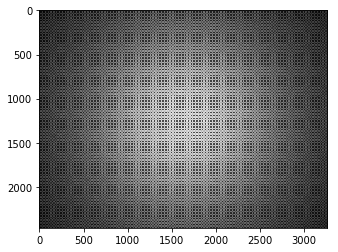

In [20]:
outimg = blc_raw.copy()
outimg = outimg.reshape((h, w))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.imshow(outimg, cmap='gray')

In [21]:
gain_map = np.zeros((h, w))
for y in range(0, h, 2):
    for x in range(0, w, 2):
        r2 = (y - center_y) * (y - center_y) + (x - center_x) * (x - center_x)
        gain = [par[i][0] * r2 + par[i][1] for i in range(4)]
        gain_map[y, x] = gain[0]
        gain_map[y, x+1] = gain[1]
        gain_map[y+1, x] = gain[2]
        gain_map[y+1, x+1] = gain[3]

In [22]:
lsc_raw = blc_raw * gain_map

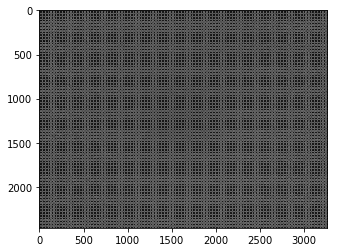

In [23]:
outimg = lsc_raw.copy()
outimg = outimg.reshape((h, w))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.imshow(outimg, cmap='gray')

In [24]:
wb_raw = raw_process.white_balance_Bayer(lsc_raw, wbg, bayer_pattern)
dms_img = raw_process.advanced_demosaic(wb_raw, bayer_pattern)
img_ccm = raw_process.color_correction_matrix(dms_img, ccm_matrix)
img_ccm[img_ccm > 1023] = 1023
img_shading = raw_process.gamma_correction(img_ccm, 2.2)

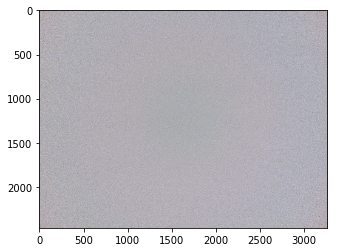

In [25]:
outimg = img_shading.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
plt.imshow(outimg)

In [34]:
center_y, center_x = h // 2, w // 2
shading_after = [[], [], []]
y = center_y - 16
for x in range(0, w - 32, 32):
    xx = x + 16
    shading_after[0].append(img_shading[y:y+32, x:x+32, 0].mean())
    shading_after[1].append(img_shading[y:y+32, x:x+32, 1].mean())
    shading_after[2].append(img_shading[y:y+32, x:x+32, 2].mean())
shading_profile = [np.array(a) / max(a) for a in shading_after]

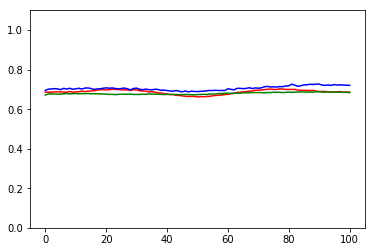

In [35]:
plt.axis(ymin=0, ymax=1.1)
plt.plot(shading_after[0], color='red')
plt.plot(shading_after[1], color='green')
plt.plot(shading_after[2], color='blue')
plt.show()